## libs

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.signal import savgol_filter
import scipy.integrate as integrate
from scipy.stats import kde as kde_stats

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from tqdm import tqdm_notebook

## initialization

In [4]:
STARS_DIRECTORY = Path('../clusters_mem/')
MAIN_DIRECTORY = Path('../')
PLOTS_DIRECTORY = Path ('../plots/')

In [5]:
CLUSTER = 'NGC_2516'

In [6]:
def read_file(filename):
    df = pd.read_csv(filename, delimiter='\\s+')
    df = df.apply(pd.to_numeric, errors='coerce')
    try:
        df.dropna(subset = ['phot_g_mean_mag','bp_rp'], inplace = True)
    except:
        pass
    return df

In [7]:
all_stars = read_file(STARS_DIRECTORY / f'{CLUSTER}.asc')

## cutting off stars in the interval

In [8]:
mask_probability = (all_stars['Ptot'] > 0.8)

stars = all_stars[mask_probability].copy()
stars['phot_color_mag'] = stars['phot_bp_mean_mag'] - stars['phot_rp_mean_mag']

In [9]:
mask_color = (stars['phot_color_mag'] > 0.2) & (stars['phot_color_mag'] < 2)

stars = stars[mask_color]

In [10]:
#optional
mask_giants = (stars['phot_g_mean_mag'] > 7)

stars = stars[mask_giants]

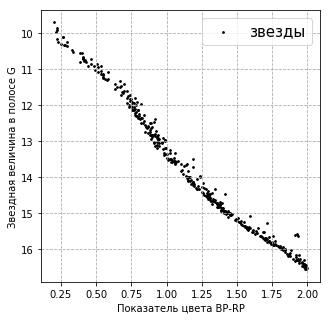

In [11]:
fig, ax = plt.subplots(figsize=(5,5 ))
ax.scatter (stars['phot_color_mag'] , stars['phot_g_mean_mag'] , c ='black', s = 3, label ='звезды')

ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()
ax.invert_yaxis()

plt.xlabel('Показатель цвета BP-RP')
plt.ylabel('Звездная величина в полосе G')
ax.tick_params(axis='both', which='major')
ax.legend(fontsize = 15)


## creating observational isochrone

In [12]:
# create data
x = stars['phot_color_mag']
y = stars['phot_g_mean_mag']
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins = int(round(200 * len(stars) / 2000, -1))
k = kde_stats.gaussian_kde([x,y],bw_method='scott')
k.set_bandwidth(bw_method=k.factor / 3)
 
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
f = zi.reshape(xi.shape)

In [13]:
isochrone_f = pd.DataFrame()
for i in range(0, nbins):
    value = f[i,:].max()
    index_y = f[i,:].argmax()
    
    isochrone_f = isochrone_f.append(
                    pd.Series([xi[i,0], yi[0,index_y]]), ignore_index=True)

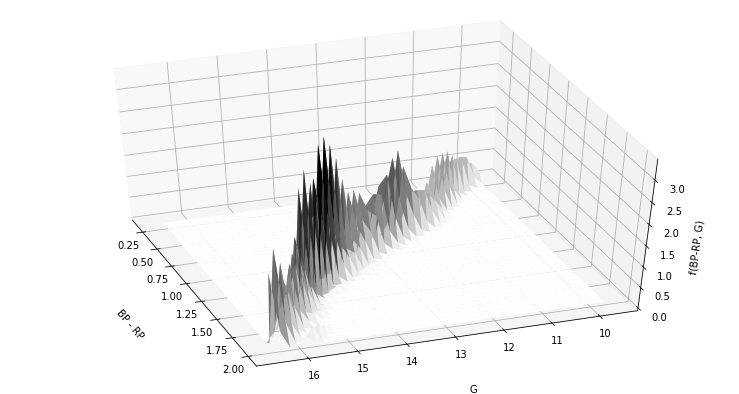

In [14]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
ax.plot_surface(xi,yi, f, cmap='binary')
ax.set_xlabel('BP - RP', labelpad=29)
ax.set_ylabel('G', labelpad=29)
ax.set_zlabel('f(BP-RP, G)', labelpad=5)
ax.invert_yaxis()

ax.view_init(45, 340)

In [15]:
isochrone_f = isochrone_f.rename(columns={0 : 'bp-rp, mag', 1 : 'g, mag'})

isochrone_f['g, mag'] = savgol_filter(isochrone_f['g, mag'], 11, 2)

In [16]:
plt.rcParams.update({'font.size': 25})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[russian]{babel}')

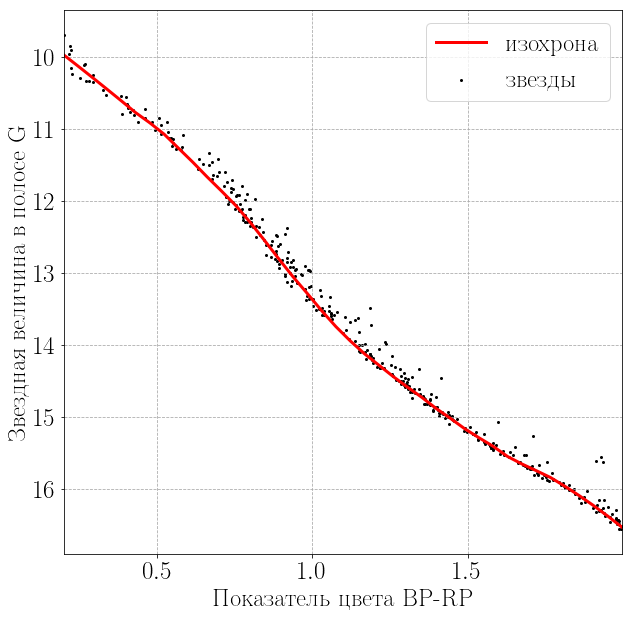

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter (x, y, c ='black', s = 4, label ='звезды')
ax.plot(isochrone_f['bp-rp, mag'],isochrone_f['g, mag'] , c ='red', lw=3,  label ='изохрона ')

ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()

ax.set_xlim(x.min(),x.max())
ax.invert_yaxis()

plt.xlabel('Показатель цвета BP-RP')
plt.ylabel('Звездная величина в полосе G')
ax.tick_params(axis='both', which='major')
ax.legend()

plt.savefig( PLOTS_DIRECTORY / f"cmd_approximation_{CLUSTER}.pdf", bbox_inches = 'tight')
plt.show()

## transition to a new coordinate system

In [18]:
func_iso = interp1d(isochrone_f['bp-rp, mag'], isochrone_f['g, mag']) 
stars['Gmag_new'] = stars['phot_g_mean_mag'] - func_iso(stars['phot_color_mag'])

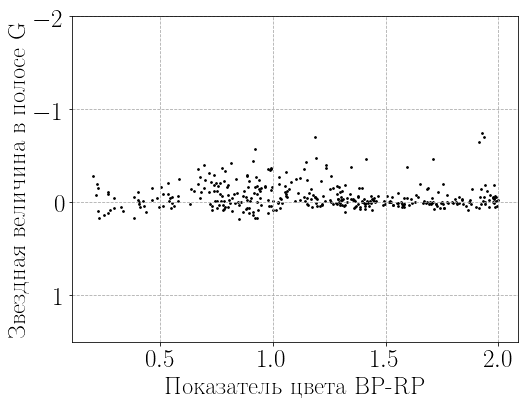

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter (stars['phot_color_mag'] , stars['Gmag_new'] , c ='black', s = 3, label ='звезды')

ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()

ax.set_ylim(-2,1.5)
ax.invert_yaxis()

plt.xlabel('Показатель цвета BP-RP')
plt.ylabel('Звездная величина в полосе G')
ax.tick_params(axis='both', which='major')

plt.savefig(PLOTS_DIRECTORY / f"horizontal_sequence_{CLUSTER}.pdf", bbox_inches = 'tight')
plt.show()

## density profile

In [20]:
num_stars = len(stars)
profile = pd.DataFrame(data = {'x' : np.linspace(-2, 1, 701)})
x = stars['Gmag_new']

# use grid search cross-validation to optimize the bandwidth
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.005, 0.2, 50)}, iid=True, cv=4) 
grid.fit(x[:, None])
bandwidth_opt = sum(grid.best_params_.values())

In [21]:
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth_opt)

kde.fit(stars[['Gmag_new']].to_numpy())
profile['density'] = np.exp(kde.score_samples(profile[['x']].to_numpy())) * num_stars

Text(0.5, 0, '$G_{new}$')

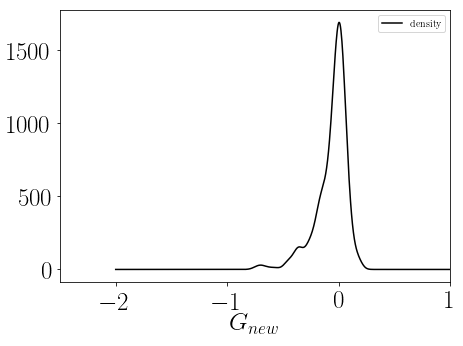

In [22]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(profile['x'], profile['density'], lw = 1.5, color = 'black')
ax.set_xlim(-2.5, 1)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel('$G_{new}$')

## approximation with gauss function

In [23]:
def f(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / c) + d

row_max = profile['density'].idxmax()
popt, pcov = curve_fit(f, profile.iloc[row_max-20:row_max+155, 0], profile.iloc[row_max-20:row_max+155, 1],
                           bounds=([0, profile.iloc[row_max, 0]-0.1, 0, -0.1],
                                   [7000, profile.iloc[row_max, 0]+0.1, 0.8, 0.1]),
                          maxfev=9000)

profile_gauss = pd.DataFrame(data={'x': profile['x']})
profile_gauss['density'] = f(profile_gauss['x'], *popt)

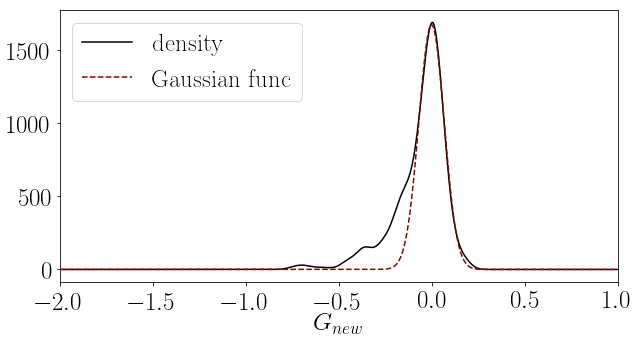

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(profile['x'], profile['density'], lw = 1.5, color = 'black')
ax.plot(profile_gauss['x'], profile_gauss['density'], lw = 1.5, ls='--', color='darkred', label='Gaussian func')

ax.set_xlim(-2, 1)

ax.legend(loc='upper left')
ax.set_xlabel('$G_{new}$')
fig.savefig(PLOTS_DIRECTORY / f"profile_{CLUSTER}.pdf", bbox_inches = 'tight')

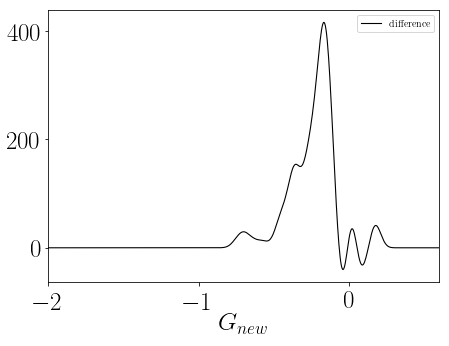

In [25]:
profile['difference'] = profile['density'] - profile_gauss['density']

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(profile['x'], profile['difference'], lw = 1.1, color = 'black')
ax.set_xlim(-2, 0.6)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel('$G_{new}$')
fig.savefig(PLOTS_DIRECTORY / f"profile_binaries_{CLUSTER}.pdf", bbox_inches = 'tight')

## estimation of binaries number

In [26]:
mask_below = (profile['difference'] < 0)
mask_left = (profile['x'] > 0)

In [27]:
profile.loc[mask_below & mask_left, 'difference'] = 0

number_of_multiples = int(integrate.trapz(profile['difference'], profile['x']))

In [28]:
# доля двойных из интегрирования профиля
number_of_multiples / len(stars)

0.24533333333333332

In [29]:
# clusters_list = pd.read_excel(MAIN_DIRECTORY / 'cluster_list_data.xlsx', index_col = 0)

In [30]:
# clusters_list.loc[CLUSTER, 'N_binaries'] = number_of_multiples
# clusters_list.loc[CLUSTER, 'N_singles'] = clusters_list.loc[CLUSTER, 'N'] - number_of_multiples
# clusters_list.loc[CLUSTER, 'fraction'] = number_of_multiples / clusters_list.loc[CLUSTER, 'N']

In [31]:
# clusters_list.to_excel(MAIN_DIRECTORY / 'cluster_list_data.xlsx')